In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import random
import re

from tqdm import tqdm
import time

import pydicom as dicom
import nibabel as nib
import SimpleITK as sitk
import monai

import torch
import torch.nn as nn
import torch.optim as optim

from monai.networks.nets import EfficientNetBN
from monai.networks.nets import ResNet
#from efficientnet_pytorch import EfficientNet
import timm

import wandb


In [2]:
SEED = 344
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True # Fix the network according to random seed
    print('Finish seeding with seed {}'.format(seed))
    
seed_everything(SEED)
print('Training on device {}'.format(device))

Finish seeding with seed 344
Training on device cuda


In [3]:
dicom_tag_columns = [
    'Columns',
    'ImageOrientationPatient',
    'ImagePositionPatient',
    'InstanceNumber',
    'PatientID',
    'PatientPosition',
    'PixelSpacing',
    'RescaleIntercept',
    'RescaleSlope',
    'Rows',
    'SeriesNumber',
    'SliceThickness',
    'path',
    'WindowCenter',
    'WindowWidth'
]

train_dicom_tags = pd.read_parquet('autodl-tmp/train_dicom_tags.parquet', columns=dicom_tag_columns)
test_dicom_tags = pd.read_parquet('autodl-tmp/test_dicom_tags.parquet', columns=dicom_tag_columns)

train_series_meta = pd.read_csv('autodl-tmp/train_series_meta.csv')
test_series_meta = pd.read_csv('autodl-tmp/test_series_meta.csv')

train_csv = pd.read_csv('autodl-tmp/train.csv')

mid_z_csv = pd.read_csv('middle_z.csv')
complete_series_meta = mid_z_csv[mid_z_csv.middle_z != -1].reset_index()
complete_series_meta

,index,patient_id,series_id,middle_z
0,0,10004,21057,128
1,1,10004,51033,131
2,2,10005,18667,120
3,3,10007,47578,127
4,4,10026,29700,110
...,...,...,...,...
4392,4393,9961,2003,133
4393,4394,9961,63032,129
4394,4395,9980,40214,94
4395,4396,9980,40466,151


In [4]:
def raw_path_gen(patient_id, series_id, train=True):
    if(train):
        path = 'autodl-tmp/train_images_resample/'
    else:
        path = 'autodl-tmp/train_images_resample/'
    
    path += str(patient_id) + '/' + str(series_id)
    
    return path

def create_3D_scans(folder, downsample_rate=1): 
    filenames = os.listdir(folder)
    filenames = [int(filename.split('.')[0]) for filename in filenames]
    filenames = sorted(filenames)
    filenames = [str(filename) + '.dcm' for filename in filenames]
        
    volume = []
    #for filename in tqdm(filenames[::downsample_rate], position=0): 
    for filename in filenames[::downsample_rate]: 
        filepath = os.path.join(folder, filename)
        ds = dicom.dcmread(filepath)
        image = ds.pixel_array
        
        if ds.PixelRepresentation == 1:
            bit_shift = ds.BitsAllocated - ds.BitsStored
            dtype = image.dtype 
            image = (image << bit_shift).astype(dtype) >>  bit_shift
        
        # find rescale params
        if ("RescaleIntercept" in ds) and ("RescaleSlope" in ds):
            intercept = float(ds.RescaleIntercept)
            slope = float(ds.RescaleSlope)
    
        # find clipping params
        center = int(ds.WindowCenter)
        width = int(ds.WindowWidth)
        low = center - width / 2
        high = center + width / 2    
        
        
        image = (image * slope) + intercept
        image = np.clip(image, low, high)

        image = (image / np.max(image) * 255).astype(np.int16)
        image = image[::downsample_rate, ::downsample_rate]
        volume.append( image )
    
    volume = np.stack(volume, axis=0)
    return volume

def plot_image_with_seg(volume, volume_seg=[], orientation='Coronal', num_subplots=20):
    # simply copy
    if len(volume_seg) == 0:
        plot_mask = 0
    else:
        plot_mask = 1
        
    if orientation == 'Coronal':
        slices = np.linspace(0, volume.shape[2]-1, num_subplots).astype(np.int16)
        volume = volume.transpose([1, 0, 2])
        if plot_mask:
            volume_seg = volume_seg.transpose([1, 0, 2])
        
    elif orientation == 'Sagittal':
        slices = np.linspace(0, volume.shape[2]-1, num_subplots).astype(np.int16)
        volume = volume.transpose([2, 0, 1])
        if plot_mask:
            volume_seg = volume_seg.transpose([2, 0, 1])

    elif orientation == 'Axial':
        slices = np.linspace(0, volume.shape[0]-1, num_subplots).astype(np.int16)
           
    rows = np.max( [np.floor(np.sqrt(num_subplots)).astype(int) - 2, 1])
    cols = np.ceil(num_subplots/rows).astype(int)
    
    fig, ax = plt.subplots(rows, cols, figsize=(cols * 2, rows * 4))
    fig.tight_layout(h_pad=0.01, w_pad=0)
    
    ax = ax.ravel()
    for this_ax in ax:
        this_ax.axis('off')

    for counter, this_slice in enumerate( slices ):
        plt.sca(ax[counter])
        
        image = volume[this_slice, :, :]
        plt.imshow(image, cmap='gray')
        
        if plot_mask:
            mask = np.where(volume_seg[this_slice, :, :], volume_seg[this_slice, :, :], np.nan)
            plt.imshow(mask, cmap='Set1', alpha=0.5)
            
def load_nii(patient_id, series_id, root='autodl-tmp/train_images_resample/'):
    path = root + str(patient_id) + '/' + str(series_id) + '.nii.gz'
    img = sitk.ReadImage(path)
    img = sitk.GetArrayFromImage(img)
    
    # img = nib.load(path)
    # img = img.get_fdata().transpose(2, 1, 0)
    
    return img

In [5]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

ds = 2

class CTDataset(Dataset):
    def __init__(self, root='autodl-tmp/train_images_resample/', augmentation=False, meta=train_series_meta, device='cpu'):
        self.device = device
        self.series_meta = meta
        self.root = root
        self.t = monai.transforms.Compose([monai.transforms.RandZoom(prob=0.5, min_zoom=0.9, max_zoom=1.1),
                                           monai.transforms.RandRotate(range_x=3.14 / 24, prob=0.5),
                                           monai.transforms.SpatialPad(spatial_size=(320//ds, 280, 280), mode="edge"),
                                           monai.transforms.RandSpatialCrop(roi_size=(320//ds, 256, 256), random_size=False),
                                           monai.transforms.NormalizeIntensity(divisor = 400)
                                ])
        self.t_val = monai.transforms.Compose([monai.transforms.NormalizeIntensity(divisor = 400)])
        
        self.aug = augmentation
        
    def __len__(self):
        #return 1100
        return len(self.series_meta)
    
    def __getitem__(self, idx):

        patient_id, series_id = self.series_meta.loc[idx, ["patient_id", "series_id"]].astype('int')
        img_a = load_nii(patient_id, series_id, self.root).astype('float32')
        #img_t = torch.from_numpy(img_a).unsqueeze(0)
        #img_t = torch.from_numpy(img_a[::2, ::2, ::2]).unsqueeze(0)
        if(self.aug):
            img_t = self.t(np.expand_dims(img_a[::ds, :, :], 0))
        else:
            #img_t = torch.from_numpy(img_a[::ds, ::ds, ::ds]).unsqueeze(0)
            img_t = self.t_val(np.expand_dims(img_a[::ds, :, :], 0))
        label_columns = [
            'bowel_injury',
            'extravasation_injury',
            'kidney_low',
            'kidney_high',
            'liver_low',
            'liver_high',
            'spleen_low',
            'spleen_high',
            #'any_injury'
        ]
        label_a = train_csv.loc[train_csv.patient_id == patient_id, label_columns].values[0].astype('float32')
        label_t = torch.from_numpy(label_a)
        return img_t, label_t

In [6]:
class EffNet(nn.Module):
    def __init__(self, ch_out=9):
        super(EffNet, self).__init__()
        #self.conv_in = nn.Conv3d(1, 3, kernel_size=5, padding=2, stride=2)
        self.net = EfficientNetBN("efficientnet-b0", pretrained=False, progress=False, spatial_dims=3, in_channels=1, num_classes=ch_out,)
    def forward(self, x):
        #x = self.conv_in(x)
        #return torch.sigmoid(self.net(x))
        return self.net(x)

class FullVolNet(nn.Module):
    def __init__(self, backbone = "tf_efficientnetv2_s.in21k_ft_in1k", 
                 ch_in = 3, ch_out = 9, slices = 15, dropout = 0.0, pretrained=True):
        super(FullVolNet, self).__init__()
        self.slices = slices
        
        self.encoder = timm.create_model(
            backbone,
            in_chans=ch_in,
            num_classes=ch_out,
            features_only=False,
            drop_rate=0.0,
            drop_path_rate=0.0,
            pretrained=False,
        )
        
        if 'efficient' in backbone and pretrained:
            self.encoder.load_state_dict(torch.load('pretrained/tf_efficientnetv2_s.in21k_ft_in1k_8class.pt'))
        elif 'convnext' in backbone and pretrained:
            self.encoder.load_state_dict(torch.load('pretrained/convnextv2_nano.fcmae_ft_in22k_in1k_384_8class.pt'))
        
        if 'efficient' in backbone:
            hdim = self.encoder.conv_head.out_channels
            self.encoder.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder.head.fc.in_features
            self.encoder.head.fc = nn.Identity()
        
        self.lstm = nn.LSTM(hdim, 256, num_layers=2, dropout=0.0, bidirectional=True, batch_first=True)
        
        self.head = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout),
            nn.LeakyReLU(0.1),
            nn.Linear(256, ch_out),
        )
        
        self.head2 = nn.Conv1d(slices, 1, 1)
        
        
    def slicer(self, img, slices):
        #img = img.squeeze(1)
        z_length = img.shape[-3]
        z_slices = (np.linspace(0, z_length, slices + 4)).astype('int')
        z_slices = z_slices[2:-2]
        #print(z_slices)
        slices_list = []
        for z in z_slices:
            slices_list.append(img[:, :, z-1:z+2, :, :])
        img_slice = torch.cat(slices_list, 1)
        return img_slice
        
    def forward(self, x):  # (bs, nslice, ch, sz, sz)
        x = self.slicer(x, self.slices)
        bs, nslice,ch, sz1, sz2 = x.shape
        x = x.view(bs*nslice, ch, sz1, sz2)
        
        feature_2d = self.encoder(x)
        feature_2d = feature_2d.view(bs, nslice, -1)
        
        feature_lstm, _ = self.lstm(feature_2d)
        feature_lstm = feature_lstm.contiguous().view(bs * nslice, -1)
        
        preds = self.head(feature_lstm)
        preds = preds.view(bs, nslice, -1).contiguous()
        preds = self.head2(preds)
        
        return preds.squeeze(1)


        

In [7]:
import sklearn.metrics

def transform_9class(label_in):
    label_out = [1 - label_in[0],
                   label_in[0],
                    1- label_in[1],
                   label_in[1],
                   (1 - label_in[2]) * (1 - label_in[3]),
                   label_in[2],
                   label_in[3],
                   (1 - label_in[4]) * (1 - label_in[5]),
                    label_in[4],
                   label_in[5],
                   (1 - label_in[6]) * (1 - label_in[7]),
                   label_in[6],
                   label_in[7]]
    return label_out

def transform_13class(label_in):
    label_out = label_in
    return label_out.tolist()

def transform_kls9class(label_in):
    label_out = [1, 1, 1, 1]
    label_out.extend(label_in.tolist())
    return label_out

def transform_kls6class(label_in):
    label_kls = label_in
    label_in = [0.5, 0.5]
    label_in.extend(label_kls.tolist())
    label_out = [1, 1, 1, 1,
                   (1 - label_in[2]) * (1 - label_in[3]),
                   label_in[2],
                   label_in[3],
                   (1 - label_in[4]) * (1 - label_in[5]),
                    label_in[4],
                   label_in[5],
                   (1 - label_in[6]) * (1 - label_in[7]),
                   label_in[6],
                   label_in[7]]
    return label_out


def loss_metrics(metrics, transform):
    preds = [transform(x) for x in metrics["predict"]]
    targets = [transform(x) for x in metrics["label"]]
    targets_any_injury = metrics["label"][:, -1]
    
    loss_list = []
    
    print("F1 score: ", sklearn.metrics.f1_score(metrics["label"], np.around(metrics["predict"]), average=None, zero_division=0.0))
    print("AUC score: ", sklearn.metrics.roc_auc_score(metrics["label"], metrics["predict"], average=None))
    # print("AUC score after transform: ", sklearn.metrics.roc_auc_score(targets, preds, average=None))
    
    
    for i in range(0, len(preds)):
        predict = preds[i]
        target = targets[i]
        
        label_pred = np.zeros(14)
        label_pred[0] = predict[0] / (predict[0] + predict[1])
        label_pred[1] = predict[1] / (predict[0] + predict[1])
        label_pred[2] = predict[2] / (predict[2] + predict[3])
        label_pred[3] = predict[3] / (predict[2] + predict[3])
        label_pred[4] = predict[4] / (predict[4] + predict[5] + predict[6])
        label_pred[5] = predict[5] / (predict[4] + predict[5] + predict[6])
        label_pred[6] = predict[6] / (predict[4] + predict[5] + predict[6])
        label_pred[7] = predict[7] / (predict[7] + predict[8] + predict[9])
        label_pred[8] = predict[8] / (predict[7] + predict[8] + predict[9])
        label_pred[9] = predict[9] / (predict[7] + predict[8] + predict[9])
        label_pred[10] = predict[10] / (predict[10] + predict[11] + predict[12])
        label_pred[11] = predict[11] / (predict[10] + predict[11] + predict[12])
        label_pred[12] = predict[12] / (predict[10] + predict[11] + predict[12])
        label_pred[13] = max([1 - label_pred[x] for x in [0, 2, 4, 7, 10]])
        
        targets_any_injury = max([1 - target[x] for x in [0, 2, 4, 7, 10]])
        
        target.append(targets_any_injury)
        label_target = np.array(target)
        
        weight = np.array([1, 2, 1, 6, 1, 2, 4, 1, 2, 4, 1, 2, 4, 6])
        
        loss_list.append(sklearn.metrics.log_loss(
            y_true=label_target,
            y_pred=label_pred,
            sample_weight=weight))
    #print("Weighted Loss: " + np.mean(loss_list))
    
    return np.mean(loss_list)
        
    
    
    #print(np.array(preds).shape)
    

In [8]:
val_df_fold1 = train_series_meta[0:1178].reset_index(drop=True)
val_df_fold2 = train_series_meta[1178:2356].reset_index(drop=True)
val_df_fold3 = train_series_meta[2356:3534].reset_index(drop=True)
val_df_fold4 = train_series_meta[3534:].reset_index(drop=True)

val_ds_fold1 = CTDataset(meta = val_df_fold1, augmentation=False)
val_dl_fold1 = DataLoader(val_ds_fold1, batch_size=4, shuffle=False, num_workers=8)
val_ds_fold2 = CTDataset(meta = val_df_fold2, augmentation=False)
val_dl_fold2 = DataLoader(val_ds_fold2, batch_size=4, shuffle=False, num_workers=8)
val_ds_fold3 = CTDataset(meta = val_df_fold3, augmentation=False)
val_dl_fold3 = DataLoader(val_ds_fold3, batch_size=4, shuffle=False, num_workers=8)
val_ds_fold4 = CTDataset(meta = val_df_fold4, augmentation=False)
val_dl_fold4 = DataLoader(val_ds_fold4, batch_size=4, shuffle=False, num_workers=8)

val_dl_list = [val_dl_fold1, val_dl_fold2, val_dl_fold3, val_dl_fold4]

weight_effnet = ['FullVol2.5D-nophase-4fold/FullVol2.5D-nophase_Effnetv2_4fold/fold1.pt',
                'FullVol2.5D-nophase-4fold/FullVol2.5D-nophase_Effnetv2_4fold/fold2.pt',
                'FullVol2.5D-nophase-4fold/FullVol2.5D-nophase_Effnetv2_4fold/fold3.pt',
                'FullVol2.5D-nophase-4fold/FullVol2.5D-nophase_Effnetv2_4fold/fold4.pt']

weight_effnetx2 = ['FullVol2.5Dx2-nophase-4fold/FullVol2.5Dx2-nophase_Effnetv2_4fold/fold1.pt',
                  'FullVol2.5Dx2-nophase-4fold/FullVol2.5Dx2-nophase_Effnetv2_4fold/fold2.pt',
                  'FullVol2.5Dx2-nophase-4fold/FullVol2.5Dx2-nophase_Effnetv2_4fold/fold3.pt',
                  'FullVol2.5Dx2-nophase-4fold/FullVol2.5Dx2-nophase_Effnetv2_4fold/fold4.pt']

weight_convnext = ['FullVol2.5D-nophase-4fold/FullVol2.5D-nophase_Convnetv2_4fold/fold1.pt',
                  'FullVol2.5D-nophase-4fold/FullVol2.5D-nophase_Convnetv2_4fold/fold2.pt',
                  'FullVol2.5D-nophase-4fold/FullVol2.5D-nophase_Convnetv2_4fold/fold3.pt',
                  'FullVol2.5D-nophase-4fold/FullVol2.5D-nophase_Convnetv2_4fold/fold4.pt']

weight_convnextx2 = ['FullVol2.5Dx2-nophase-4fold/FullVol2.5Dx2-nophase_Convnetv2_4fold/fold1.pt',
                    'FullVol2.5Dx2-nophase-4fold/FullVol2.5Dx2-nophase_Convnetv2_4fold/fold2.pt',
                    'FullVol2.5Dx2-nophase-4fold/FullVol2.5Dx2-nophase_Convnetv2_4fold/fold3.pt',
                    'FullVol2.5Dx2-nophase-4fold/FullVol2.5Dx2-nophase_Convnetv2_4fold/fold4.pt']

weight_effnet3d = ['Effnet3D-nophase-4fold/Effnet3D-nophase_4fold/fold1.pt',
                  'Effnet3D-nophase-4fold/Effnet3D-nophase_4fold/fold2.pt',
                  'Effnet3D-nophase-4fold/Effnet3D-nophase_4fold/fold3.pt',
                  'Effnet3D-nophase-4fold/Effnet3D-nophase_4fold/fold4.pt']

In [9]:
# autodl-tmp/fullvol_outputs

In [10]:
fullvol_columns = ['bowel_injury',
                'extravasation_injury',
                'kidney_low',
                'kidney_high',
                'liver_low',
                'liver_high',
                'spleen_low',
                'spleen_high',]

effnet3d_columns = ['bowel_healthy',
                    'bowel_injury',
                    'extravasation_healthy',
                    'extravasation_injury',
                    'kidney_healthy',
                    'kidney_low',
                    'kidney_high',
                    'liver_healthy',
                    'liver_low',
                    'liver_high',
                    'spleen_healthy',
                    'spleen_low',
                    'spleen_high',]

fullvol_effnet = pd.DataFrame(columns=fullvol_columns)
fullvol_effnetx2 = pd.DataFrame(columns=fullvol_columns)
fullvol_convnext = pd.DataFrame(columns=fullvol_columns)
fullvol_convnextx2 = pd.DataFrame(columns=fullvol_columns)
fullvol_labels = pd.DataFrame(columns=fullvol_columns)
fullvol_effnet3d = pd.DataFrame(columns=effnet3d_columns)
fullvol_effnet3d

,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high


In [11]:
metrics_effnet = {'predict': [], 'label' : []}
metrics_effnetx2 = {'predict': [], 'label' : []}
metrics_convnext = {'predict': [], 'label' : []}
metrics_convnextx2 = {'predict': [], 'label' : []}
metrics_effnet3d = {'predict': [], 'label' : []}

for i in range(0, 4):
    
    val_dl = val_dl_list[i]
    for imgs, labels in tqdm(val_dl):
        imgs = imgs.to(device)
        labels = labels.to(device)
        # # effnet
        # backbone = "tf_efficientnetv2_s.in21k_ft_in1k"
        # model = FullVolNet(backbone=backbone, ch_out = 8, pretrained=False).to(device)
        # model.load_state_dict(torch.load(weight_effnet[i]))
        # model.eval()
        # with torch.no_grad():
        #     outputs = model(imgs[:, :, :, ::2, ::2])
        #     #outputs = model(imgs.unsqueeze(1))
        #     outputs = torch.sigmoid(outputs)
        #     metrics_effnet['predict'].extend((outputs.to('cpu').detach().numpy()).tolist())
        #     metrics_effnet['label'].extend((labels.to('cpu').detach().numpy()).tolist())
            
#         # convnext
#         backbone = 'convnextv2_nano.fcmae_ft_in22k_in1k_384'
#         model = FullVolNet(backbone=backbone, ch_out = 8, pretrained=False).to(device)
#         model.load_state_dict(torch.load(weight_convnext[i]))
#         model.eval()
#         with torch.no_grad():
#             outputs = model(imgs[:, :, :, ::2, ::2])
#             #outputs = model(imgs.unsqueeze(1))
#             outputs = torch.sigmoid(outputs)
#             metrics_convnext['predict'].extend((outputs.to('cpu').detach().numpy()).tolist())
#             metrics_convnext['label'].extend((labels.to('cpu').detach().numpy()).tolist())
        
        # # effnetx2
        # backbone = "tf_efficientnetv2_s.in21k_ft_in1k"
        # model = FullVolNet(backbone=backbone, ch_out = 8, pretrained=False).to(device)
        # model.load_state_dict(torch.load(weight_effnetx2[i]))
        # model.eval()
        # with torch.no_grad():
        #     outputs = model(imgs)
        #     #outputs = model(imgs.unsqueeze(1))
        #     outputs = torch.sigmoid(outputs)
        #     metrics_effnetx2['predict'].extend((outputs.to('cpu').detach().numpy()).tolist())
        #     metrics_effnetx2['label'].extend((labels.to('cpu').detach().numpy()).tolist())
            
        # # convnextx2
        # backbone = 'convnextv2_nano.fcmae_ft_in22k_in1k_384'
        # model = FullVolNet(backbone=backbone, ch_out = 8, pretrained=False).to(device)
        # model.load_state_dict(torch.load(weight_convnextx2[i]))
        # model.eval()
        # with torch.no_grad():
        #     outputs = model(imgs)
        #     #outputs = model(imgs.unsqueeze(1))
        #     outputs = torch.sigmoid(outputs)
        #     metrics_convnextx2['predict'].extend((outputs.to('cpu').detach().numpy()).tolist())
        #     metrics_convnextx2['label'].extend((labels.to('cpu').detach().numpy()).tolist())
        
        # effnet3d
        model = EffNet(ch_out=13).to(device)
        model.load_state_dict(torch.load(weight_effnet3d[i]))
        model.eval()
        with torch.no_grad():
            outputs = model(imgs[:, :, :, ::2, ::2])
            #outputs = model(imgs.unsqueeze(1))
            outputs = torch.sigmoid(outputs)
            metrics_effnet3d['predict'].extend((outputs.to('cpu').detach().numpy()).tolist())
            metrics_effnet3d['label'].extend((labels.to('cpu').detach().numpy()).tolist())
    
#     metrics_effnet['predict'] = np.array(metrics_effnet['predict'])
#     metrics_effnet['label'] = np.array(metrics_effnet['label'])
#     weighted_loss = loss_metrics(metrics_effnet, transform_9class)
    
#     metrics_effnetx2['predict'] = np.array(metrics_effnetx2['predict'])
#     metrics_effnetx2['label'] = np.array(metrics_effnetx2['label'])
#     weighted_loss = loss_metrics(metrics_effnetx2, transform_9class)

 #    [0.73890339 0.72617573 0.69875816 0.86453416 0.68637631 0.7738663369  0.67781067 0.82793679]
 #    [0.77554695 0.7308704  0.73534463 0.83195652 0.73175591 0.8018366841  0.68756256 0.8529517 ]

100%|██████████| 295/295 [03:34<00:00,  1.37it/s]


In [12]:
fullvol_labels = pd.DataFrame(data = metrics_convnextx2['label'], columns=fullvol_columns)

In [13]:
# fullvol_labels.to_csv('autodl-tmp/fullvol_outputs/fullvol_labels.csv', index=None)

In [14]:
fullvol_effnet = pd.DataFrame(data = metrics_effnet['predict'], columns=fullvol_columns)
fullvol_effnet

,bowel_injury,extravasation_injury,kidney_low,kidney_high,liver_low,liver_high,spleen_low,spleen_high


In [15]:
# fullvol_effnet.to_csv('autodl-tmp/fullvol_outputs/fullvol_effnet.csv', index=None)

In [16]:
fullvol_effnetx2 = pd.DataFrame(data = metrics_effnetx2['predict'], columns=fullvol_columns)
fullvol_effnetx2

,bowel_injury,extravasation_injury,kidney_low,kidney_high,liver_low,liver_high,spleen_low,spleen_high


In [17]:
# fullvol_effnetx2.to_csv('autodl-tmp/fullvol_outputs/fullvol_effnetx2.csv', index=None)

In [18]:
fullvol_convnext = pd.DataFrame(data = metrics_convnext['predict'], columns=fullvol_columns)
fullvol_convnext

,bowel_injury,extravasation_injury,kidney_low,kidney_high,liver_low,liver_high,spleen_low,spleen_high


In [19]:
# fullvol_convnext.to_csv('autodl-tmp/fullvol_outputs/fullvol_convnext.csv', index=None)

In [20]:
fullvol_convnextx2 = pd.DataFrame(data = metrics_convnextx2['predict'], columns=fullvol_columns)
fullvol_convnextx2

,bowel_injury,extravasation_injury,kidney_low,kidney_high,liver_low,liver_high,spleen_low,spleen_high


In [21]:
# fullvol_convnextx2.to_csv('autodl-tmp/fullvol_outputs/fullvol_convnextx2.csv', index=None)

In [22]:
fullvol_effnet3d = pd.DataFrame(data = metrics_effnet3d['predict'], columns=effnet3d_columns)
fullvol_effnet3d

,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high
0,0.996671,0.073443,0.970666,0.273717,0.980127,0.406375,0.127499,0.912094,0.659508,0.159708,0.965494,0.304699,0.089540
1,0.992310,0.215527,0.964158,0.295094,0.990998,0.215749,0.043999,0.970771,0.371768,0.040670,0.963973,0.292735,0.099048
2,0.999154,0.015095,0.981192,0.207288,0.997861,0.030506,0.007793,0.995856,0.075093,0.003487,0.996070,0.054955,0.003979
3,0.995038,0.102475,0.958846,0.333140,0.991861,0.110155,0.044128,0.975263,0.279076,0.069263,0.936573,0.392326,0.263904
4,0.998852,0.019741,0.977899,0.294626,0.988238,0.170935,0.091181,0.855950,0.734790,0.373686,0.982154,0.219429,0.027288
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4706,0.998246,0.073562,0.986882,0.161607,0.986212,0.394772,0.023763,0.949478,0.593763,0.029470,0.985086,0.275858,0.014770
4707,0.996943,0.211615,0.983138,0.214146,0.961993,0.680073,0.120000,0.895921,0.767355,0.028465,0.988230,0.225698,0.009242
4708,0.978817,0.300000,0.692292,0.893826,0.724089,0.874487,0.853835,0.939479,0.538957,0.065479,0.179993,0.916101,0.984585
4709,0.995181,0.073023,0.884172,0.700080,0.904908,0.702342,0.440111,0.956263,0.400704,0.114331,0.501027,0.893196,0.877284


In [25]:
fullvol_effnet3d.to_csv('autodl-tmp/fullvol_outputs/effnet3d.csv', index=None)

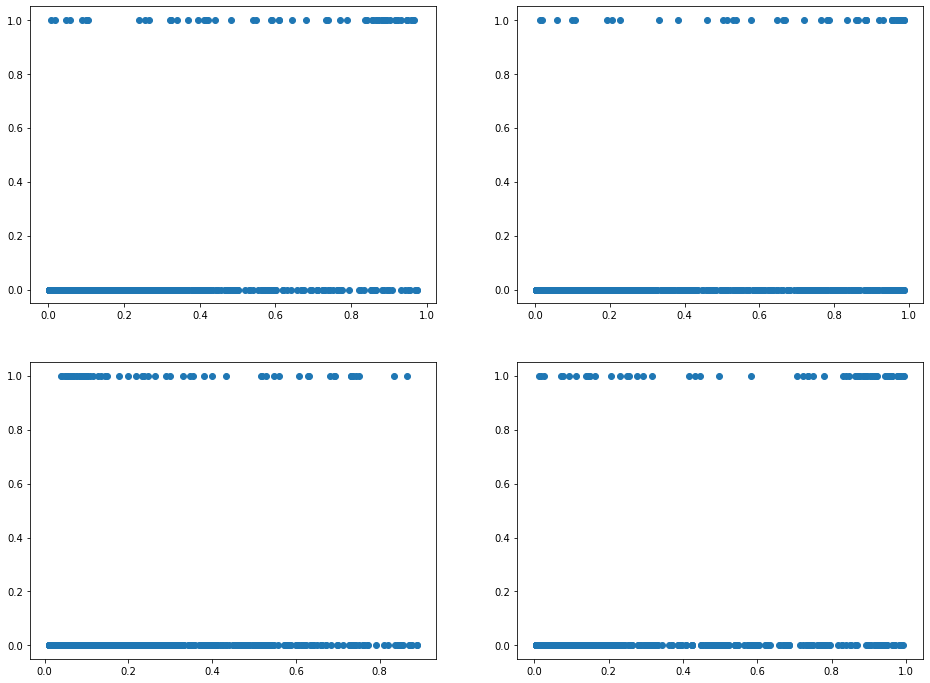

In [23]:
l = -1

metrics_print = metrics_effnet3d

plt.figure(figsize=(16, 12))
plt.subplot(2, 2, 1)
plt.scatter(np.array(metrics_print['predict'])[0:1178, l], np.array(metrics_print['label'])[0:1178, l])
plt.subplot(2, 2, 2)
plt.scatter(np.array(metrics_print['predict'])[1178:2356, l], np.array(metrics_print['label'])[1178:2356, l])
plt.subplot(2, 2, 3)
plt.scatter(np.array(metrics_print['predict'])[2356:3534, l], np.array(metrics_print['label'])[2356:3534, l])
plt.subplot(2, 2, 4)
plt.scatter(np.array(metrics_print['predict'])[3534:, l], np.array(metrics_print['label'])[3534:, l])

In [24]:
# metric = {'predict': np.array(metrics_convnextx2['predict']), 'label': np.array(metrics_convnextx2['label'])}

# weighted_loss = loss_metrics(metric, transform_9class)